In [1]:
!pip install torch
!pip install torchvision
!pip install torchsummary
!pip install torchmetrics
!pip install torcheval

  Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
  Using cached lightning_utilities-0.11.8-py3-none-any.whl.metadata (5.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 11.0 MB/s eta 0:00:0000:010:01
Using cached lightning_utilities-0.11.8-py3-none-any.whl (26 kB)
  Using cached torcheval-0.0.7-py3-none-any.whl.metadata (8.6 kB)
Using cached torcheval-0.0.7-py3-none-any.whl (179 kB)


In [2]:
import os
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torcheval
from torch.utils.data import Dataset
from torch.utils.data import Subset

## Adding timestamps to the /food-timestamp/ folder

In [3]:
train_dir = '../../Datasets/food/training'
test_dir = '../../Datasets/food/evaluation'
output_dir = '../../Datasets/food-timestamp'
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat',
           'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit')

In [40]:
def add_timestamp_to_image(image_path, output_path):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    font = ImageFont.load_default()
    text_position = (10, 10)
    draw.text(text_position, timestamp, font=font, fill=(255, 255, 255))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    image.save(output_path)

def process_directory(input_dir, output_dir):
    for class_name in classes:
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                output_path = os.path.join(output_class_dir, image_name)
                if os.path.isfile(image_path):
                    add_timestamp_to_image(image_path, output_path)

process_directory(train_dir, os.path.join(output_dir, 'training'))
process_directory(test_dir, os.path.join(output_dir, 'evaluation'))

print("Timestamps added to all images")

Timestamps added to all images


In [4]:
class MyImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

class PairedDataset(Dataset):
    def __init__(self, stamped_dataset, original_dataset):
        self.stamped_dataset = stamped_dataset
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.stamped_dataset)

    def __getitem__(self, idx):
        stamped_img, _ = self.stamped_dataset[idx]
        original_img, _ = self.original_dataset[idx]
        return stamped_img, original_img


def imshow(img, s=""):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if s and not '\n' in s:
        s = ' '.join(s.split())
        p = s.find(' ', int(len(s) / 2))
        s = s[:p] + "\n" + s[p + 1:]
    plt.text(0, -20, s)
    plt.show()

## Preparing data
Normalizing and resizing. Making pairs of original images and stamped images.

In [5]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dir = '../../Datasets/food/training'
#test_dir = '../../Datasets/food/evaluation'
timestamp_train_dir = '../../Datasets/food-timestamp/training'

train_dataset = MyImageFolder(train_dir, transform=transform)
#test_dataset = MyImageFolder(test_dir, transform=transform)
timestamp_dataset = MyImageFolder(timestamp_train_dir, transform=transform)

#test_dataset.class_to_idx = train_dataset.class_to_idx
timestamp_dataset.class_to_idx = train_dataset.class_to_idx

# Pairing datasets and using a subset
paired_dataset = PairedDataset(timestamp_dataset, train_dataset)
subset_indices = list(range(1000))
paired_dataset = Subset(paired_dataset, subset_indices)

train_loader = torch.utils.data.DataLoader(paired_dataset, batch_size=32, shuffle=True, num_workers=4)


#trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

visualizer_no_timestamp = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
visualizer_timestamp = torch.utils.data.DataLoader(timestamp_dataset, batch_size=1, shuffle=False, num_workers=4)

## Displaying an image without timestamp, and an image with timestamp

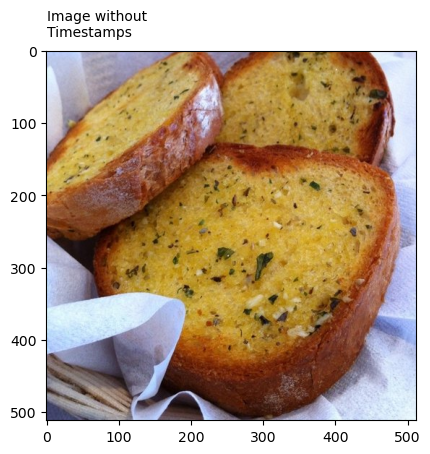

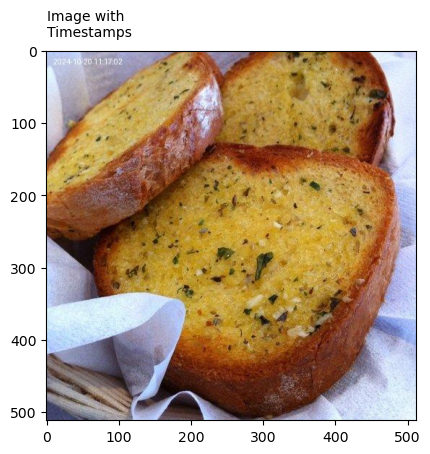

In [6]:
## Image without timestamp
dataiter = iter(visualizer_no_timestamp)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images), "Image without Timestamps")

## Image with timestamp
dataiter = iter(visualizer_timestamp)
timestamp_images, timestamp_labels = next(dataiter)
imshow(torchvision.utils.make_grid(timestamp_images), "Image with Timestamps")


# Autoencoder
## Defining the autoencoder

In [7]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 256, 256)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Output: (128, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# Output: (256, 64, 64)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),# Output: (512, 32, 32)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),# Output: (512, 16, 16)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),# Output: (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.dec_conv5 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), # Output: (512, 16, 16)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),# Output: (512, 32, 32)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),# Output: (256, 64, 64)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1), # Output: (128, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 256, 256)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),   # Output: (3, 512, 512)
            nn.Tanh(),
        )

    def forward(self, x):
        enc1 = self.enc_conv1(x)      # (64, 256, 256)
        enc2 = self.enc_conv2(enc1)   # (128, 128, 128)
        enc3 = self.enc_conv3(enc2)   # (256, 64, 64)
        enc4 = self.enc_conv4(enc3)   # (512, 32, 32)
        enc5 = self.enc_conv5(enc4)   # (512, 16, 16)

        bottleneck = self.bottleneck(enc5)  # (512, 8, 8)

        dec5 = self.dec_conv5(bottleneck)           # (512, 16, 16)
        dec5 = torch.cat((dec5, enc5), dim=1)       # (512 + 512, 16, 16)
        dec4 = self.dec_conv4(dec5)                 # (512, 32, 32)
        dec4 = torch.cat((dec4, enc4), dim=1)       # (512 + 512, 32, 32)
        dec3 = self.dec_conv3(dec4)                 # (256, 64, 64)
        dec3 = torch.cat((dec3, enc3), dim=1)       # (256 + 256, 64, 64)
        dec2 = self.dec_conv2(dec3)                 # (128, 128, 128)
        dec2 = torch.cat((dec2, enc2), dim=1)       # (128 + 128, 128, 128)
        dec1 = self.dec_conv1(dec2)                 # (64, 256, 256)
        dec1 = torch.cat((dec1, enc1), dim=1)       # (64 + 64, 256, 256)
        output = self.final_layer(dec1)             # (3, 512, 512)
        return output


## Training the Autoencoder

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for stamped_imgs, original_imgs in train_loader:
        stamped_imgs = stamped_imgs.to(device)
        original_imgs = original_imgs.to(device)

        outputs = model(stamped_imgs)
        loss = criterion(outputs, original_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/20], Loss: 0.1675
Epoch [2/20], Loss: 0.0497
Epoch [3/20], Loss: 0.0331
Epoch [4/20], Loss: 0.0245
Epoch [5/20], Loss: 0.0204
Epoch [6/20], Loss: 0.0176
Epoch [7/20], Loss: 0.0160
Epoch [8/20], Loss: 0.0146
Epoch [9/20], Loss: 0.0152
Epoch [10/20], Loss: 0.0140
Epoch [11/20], Loss: 0.0128
Epoch [12/20], Loss: 0.0127
Epoch [13/20], Loss: 0.0117
Epoch [14/20], Loss: 0.0113
Epoch [15/20], Loss: 0.0108
Epoch [16/20], Loss: 0.0098
Epoch [17/20], Loss: 0.0100
Epoch [18/20], Loss: 0.0099
Epoch [19/20], Loss: 0.0092
Epoch [20/20], Loss: 0.0089


## Validating the autoencoder

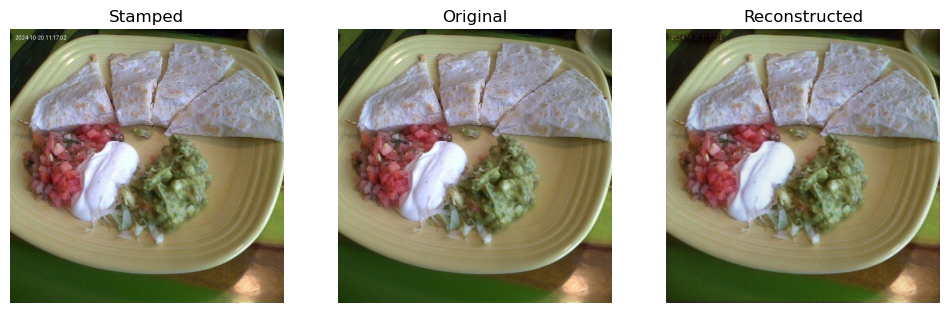

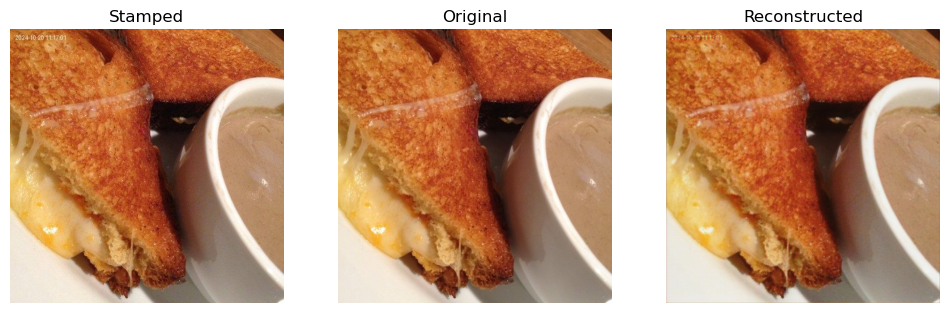

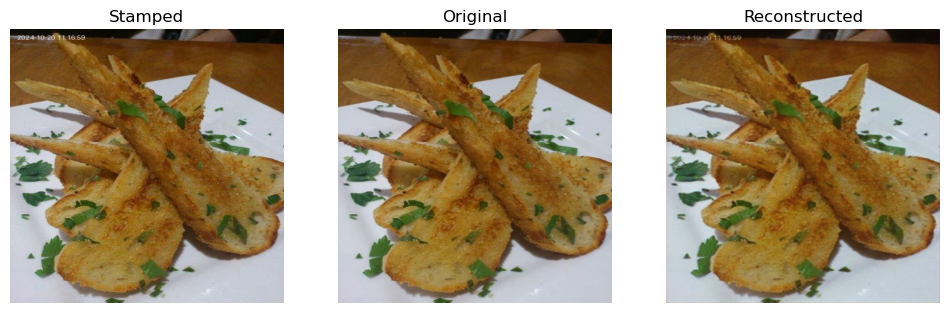

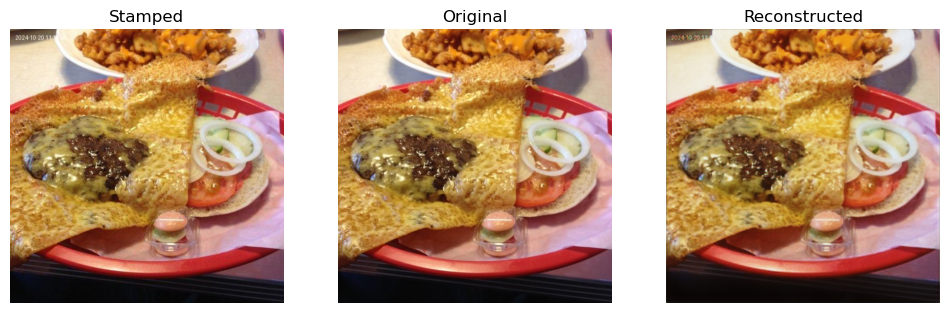

In [11]:
import matplotlib.pyplot as plt

def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5  # Convert from [-1, 1] to [0, 1]
    return img_tensor

dataiter = iter(train_loader)
stamped_imgs, original_imgs = next(dataiter)
stamped_imgs = stamped_imgs.to(device)
original_imgs = original_imgs.to(device)

model.eval()
with torch.no_grad():
    reconstructed = model(stamped_imgs)

stamped_imgs = denormalize(stamped_imgs.cpu())
original_imgs = denormalize(original_imgs.cpu())
reconstructed = denormalize(reconstructed.cpu())

num_images = 4
for idx in range(num_images):
    plt.figure(figsize=(12, 4))

    # Stamped Image
    plt.subplot(1, 3, 1)
    plt.imshow(stamped_imgs[idx].permute(1, 2, 0))
    plt.title('Stamped')
    plt.axis('off')

    # Original Image
    plt.subplot(1, 3, 2)
    plt.imshow(original_imgs[idx].permute(1, 2, 0))
    plt.title('Original')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed[idx].permute(1, 2, 0))
    plt.title('Reconstructed')
    plt.axis('off')

    plt.show()
